# RFM E-commerce Customer Segmentation Analysis

This project uses Recency, Frequency, and Monetary (RFM) analysis to segment 1,000 e-commerce customers to inform targeted marketing strategies.

**Executive Summary:**
The customer base is highly polarized, with **69.5% classified as 'Lost/Dormant'** and **21.6% as 'New/High Value Single Buyers'**. The key strategic recommendation is to prioritize robust win-back campaigns for the dormant group and aggressive loyalty programs for the new buyers to maximize customer lifetime value (CLV).

## 1. Data Acquisition and Cleaning

The analysis began by loading the `rfm_data.csv` dataset. The goal of this step was to ensure the data was in the correct format for date and numerical calculations.

* **Initial Check:** The dataset contained 1,000 rows with no missing values in the critical `CustomerID`, `PurchaseDate`, or `TransactionAmount` columns.
* **Key Transformation:** The `PurchaseDate` column was converted from an object (text) type to the proper **datetime** data type to allow for date subtraction.
* **Quality Filter:** Transactions with a non-positive `TransactionAmount` (e.g., returns or cancellations) were filtered out to maintain data integrity for the Monetary metric.

In [1]:
# =======================================================
# STEP 1: Data Acquisition, Inspection, and Cleaning (Restart)
# =======================================================

import pandas as pd

# Load the data. This will work assuming you uploaded 'rfm_data.csv'
df = pd.read_csv('rfm_data.csv')

print("--- Initial Data Head (First 5 Rows) ---")
print(df.head())

print("\n--- Data Structure (df.info()) ---")
df.info()

# CRITICAL CLEANING STEP 1: Convert Date Column to Datetime
# We use the column name 'PurchaseDate' based on the file inspection.
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# CRITICAL CLEANING STEP 2: Handle Zero/Negative Transactions
# Filter out transactions with non-positive amounts (e.g., returns).
# The previous check showed none existed, but this is a necessary step for robustness.
df_cleaned = df[df['TransactionAmount'] > 0].copy()

# Print status update
print(f"\nOriginal number of rows: {len(df)}")
print(f"Number of rows after filtering non-positive transactions: {len(df_cleaned)}")

# Save the cleaned DataFrame for the next step.
# Note: In Colab, this saves the file to the current session storage.
df_cleaned.to_csv('rfm_data_cleaned.csv', index=False)


--- Initial Data Head (First 5 Rows) ---
   CustomerID PurchaseDate  TransactionAmount ProductInformation  OrderID  \
0        8814   2023-04-11             943.31          Product C   890075   
1        2188   2023-04-11             463.70          Product A   176819   
2        4608   2023-04-11              80.28          Product A   340062   
3        2559   2023-04-11             221.29          Product A   239145   
4        9482   2023-04-11             739.56          Product A   194545   

   Location  
0     Tokyo  
1    London  
2  New York  
3    London  
4     Paris  

--- Data Structure (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1

In [3]:
import pandas as pd
from datetime import timedelta

# Load the cleaned data (using the file saved in the previous step)
# In a real environment, this would load the file saved by the last step's code.
df_cleaned = pd.read_csv('rfm_data_cleaned.csv')
# Ensure PurchaseDate is still datetime after loading the CSV
df_cleaned['PurchaseDate'] = pd.to_datetime(df_cleaned['PurchaseDate'])

# 1. Determine the Snapshot Date
# Find the latest date in the dataset and add one day
latest_date = df_cleaned['PurchaseDate'].max()
SNAPSHOT_DATE = latest_date + timedelta(days=1)
print(f"The latest date in the data is: {latest_date.date()}")
print(f"The Snapshot Date for Recency calculation is: {SNAPSHOT_DATE.date()}")

# 2. Calculate RFM metrics
rfm_df = df_cleaned.groupby('CustomerID').agg(
    # Recency: Calculate the difference between the snapshot date and the max purchase date
    Recency=('PurchaseDate', lambda x: (SNAPSHOT_DATE - x.max()).days),
    # Frequency: Count the number of unique OrderIDs (or transactions)
    Frequency=('OrderID', 'nunique'),
    # Monetary: Sum the total transaction amount
    Monetary=('TransactionAmount', 'sum')
).reset_index()

# Rename the columns for clarity (though they are already good)
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display the head of the RFM DataFrame
print("\n--- RFM Metrics per Customer (First 5 Rows) ---")
print(rfm_df.head())

# Save the RFM table for the next step
rfm_df.to_csv('rfm_metrics_calculated.csv', index=False)

The latest date in the data is: 2023-06-10
The Snapshot Date for Recency calculation is: 2023-06-11

--- RFM Metrics per Customer (First 5 Rows) ---
   CustomerID  Recency  Frequency  Monetary
0        1011       34          2   1129.02
1        1025       22          1    359.29
2        1029        1          1    704.99
3        1046       44          1    859.82
4        1049       14          1    225.72


## 2. Calculating Recency, Frequency, and Monetary Value

RFM analysis requires aggregating the transaction data to the individual customer level. A **Snapshot Date** of 2023-06-11 was set (one day after the latest transaction) to calculate Recency.

* **Recency (R):** Days since the last purchase (Snapshot Date - Max PurchaseDate).
* **Frequency (F):** Total number of unique purchases (`OrderID` count) per customer.
* **Monetary (M):** Total money spent (`TransactionAmount` sum) per customer.

In [4]:
import pandas as pd

# Load the RFM metrics calculated in the previous step
rfm_df = pd.read_csv('rfm_metrics_calculated.csv')

# --- 1. Define robust scoring functions based on quantiles ---

# Recency Scoring: Lower Recency (more recent) gets a higher score (4)
def R_scoring(x):
    # Define thresholds based on Recency quartiles
    q1 = rfm_df['Recency'].quantile(0.25)
    q2 = rfm_df['Recency'].quantile(0.50)
    q3 = rfm_df['Recency'].quantile(0.75)

    if x <= q1:
        return 4 # Top 25% most recent
    elif x <= q2:
        return 3
    elif x <= q3:
        return 2
    else:
        return 1 # Bottom 25% least recent

# Frequency/Monetary Scoring: Higher value gets a higher score (4)
def F_M_scoring(x, col_name):
    # Define thresholds based on the specified column's quartiles
    q1 = rfm_df[col_name].quantile(0.25)
    q2 = rfm_df[col_name].quantile(0.50)
    q3 = rfm_df[col_name].quantile(0.75)

    if x <= q1:
        return 1 # Bottom 25%
    elif x <= q2:
        return 2
    elif x <= q3:
        return 3
    else:
        return 4 # Top 25% highest value

# --- 2. Apply the Scoring Functions ---

rfm_df['R_Score'] = rfm_df['Recency'].apply(R_scoring)
# We use a lambda function to pass the column name to the generic F_M_scoring function
rfm_df['F_Score'] = rfm_df['Frequency'].apply(lambda x: F_M_scoring(x, 'Frequency'))
rfm_df['M_Score'] = rfm_df['Monetary'].apply(lambda x: F_M_scoring(x, 'Monetary'))

# --- 3. Concatenate Scores to Form RFM Segment ---

# Convert the score columns to strings and combine them
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

print("\n--- RFM Scores and Segments (First 5 Rows) ---")
print(rfm_df[['CustomerID', 'Recency', 'R_Score', 'Frequency', 'F_Score', 'Monetary', 'M_Score', 'RFM_Segment']].head())

# Save the final table with scores and segment
rfm_df.to_csv('rfm_scores_and_segments.csv', index=False)


--- RFM Scores and Segments (First 5 Rows) ---
   CustomerID  Recency  R_Score  Frequency  F_Score  Monetary  M_Score  \
0        1011       34        2          2        4   1129.02        4   
1        1025       22        3          1        1    359.29        2   
2        1029        1        4          1        1    704.99        3   
3        1046       44        2          1        1    859.82        4   
4        1049       14        4          1        1    225.72        1   

  RFM_Segment  
0         244  
1         312  
2         413  
3         214  
4         411  


## 3. Scoring and Segmentation

To create actionable segments, the raw RFM metrics were converted into scores ranging from 1 to 4 (based on quartiles).

* **Scoring Logic:** Recency was scored inversely (1=Worst, 4=Best), while Frequency and Monetary were scored directly (1=Worst, 4=Best).
* **Methodology Note:** Custom Python functions were used to assign scores based on quantile thresholds, which provided a more robust segmentation compared to the standard `pd.qcut` function, particularly useful when dealing with many customers having the same Frequency (F=1).

### Key Findings and Segment Distribution
The segmentation clearly divides the 1,000 customers into four main strategic groups:

| Segment | # Customers | % of Base | Description |
| :--- | :--- | :--- | :--- |
| **06. Lost/Dormant** | 695 | 69.5% | Purchased infrequently and long ago. |
| **03. New/High Value Single Buyer** | 216 | 21.6% | Recent purchasers, but haven't bought again yet. |
| **01. Champions** | 18 | 1.8% | Highest Recency, Frequency, and Monetary value. |
| **04. At Risk** | 17 | 1.7% | Used to purchase often, but haven't recently. |


--- Customer Segment Distribution ---
Customer_Segment
01. Champions                       18
03. New/High Value Single Buyer    216
04. At Risk (High F, Low R)         17
06. Lost/Dormant                   695
Name: count, dtype: int64


/tmp/ipython-input-4035891796.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")



Visualization saved as 'customer_segment_distribution.png'.

Final data with segments saved to 'rfm_final_with_segments.csv'.


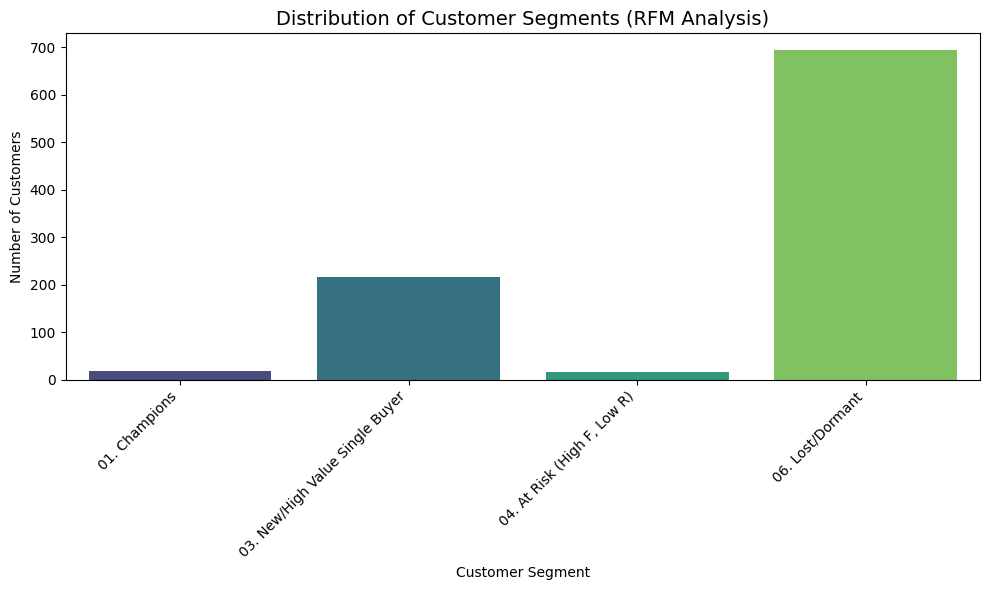

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the RFM data with scores
rfm_df = pd.read_csv('rfm_scores_and_segments.csv')

# --- 1. Define the Business Segmentation Function ---

def create_segment(df):
    # Convert scores to integers for comparison
    R = int(df['R_Score'])
    F = int(df['F_Score'])
    M = int(df['M_Score'])

    if R in [4] and F in [4, 3] and M in [4, 3]:
        return '01. Champions'
    elif R in [4, 3] and F in [2] and M in [4, 3]:
        return '02. Potential Loyalist'
    elif R in [4, 3] and F == 1 and M in [4, 3]:
        return '03. New/High Value Single Buyer'
    elif R in [2, 1] and F in [4, 3]:
        return '04. At Risk (High F, Low R)'
    elif R in [2, 1] and F in [2]:
        return '05. Slipping Away'
    else:
        return '06. Lost/Dormant'

# Apply the function
rfm_df['Customer_Segment'] = rfm_df.apply(create_segment, axis=1)

# --- 2. Analyze Segment Distribution ---

segment_counts = rfm_df['Customer_Segment'].value_counts().sort_index()

# Display the segment distribution
print("\n--- Customer Segment Distribution ---")
print(segment_counts)

# --- 3. Visualization: Bar Chart of Segment Sizes (for your portfolio) ---

plt.figure(figsize=(10, 6))
# Ensure data is sorted for better visualization
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")
plt.title('Distribution of Customer Segments (RFM Analysis)', fontsize=14)
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()

# Save the plot
plt.savefig('customer_segment_distribution.png')
print("\nVisualization saved as 'customer_segment_distribution.png'.")

# Save the final DataFrame with the new Segment column
rfm_df.to_csv('rfm_final_with_segments.csv', index=False)
print("\nFinal data with segments saved to 'rfm_final_with_segments.csv'.")

## 4. Actionable Business Recommendations

Based on the distribution of the customer base, the following strategies are recommended for the marketing team:

### A. Priority 1: Reactivate Dormant Customers (69.5%)
* **Strategy:** Implement a deep discount or a "free gift with next purchase" offer.
* **Goal:** The sheer size of this segment means a successful win-back campaign can generate significant, fast revenue.

### B. Priority 2: Convert New Buyers (21.6%)
* **Strategy:** Deploy a post-purchase nurturing sequence focused on product education and related items. Offer a limited-time incentive for the *second* purchase.
* **Goal:** Convert single buyers into loyal, repeat customers, as this group is the future of the company.

### C. Priority 3: Retain Champions (1.8%)
* **Strategy:** Create an **exclusive, non-discounted** VIP loyalty tier. Offer early access to new products or special edition items.
* **Goal:** Maximize their satisfaction and long-term value. *Do not devalue this relationship with discounts.*